In [50]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers


import tensorflow as tf
from tensorflow.keras import layers
import chess
import numpy as np


In [51]:
def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    isWhite = parts[1] == 'w'
    castling_part = parts[2]

    # Convert the board position to a binary matrix
    board = chess.Board(fen)
    binary_board = np.zeros((8, 8, 6), dtype=np.float32)
    piece_amount = np.zeros((12), dtype=np.float32)
    pieces = {'p': [0, 1.0], 'r': [1, 1.0], 'n': [2, 1.0], 'b': [3, 1.0], 'q': [4, 1.0], 'k': [5, 1.0],
              'P': [0, -1.0], 'R': [1, -1.0], 'N': [2, -1.0], 'B': [3, -1.0], 'Q': [4, -1.0], 'K': [5, -1.0]}
    
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            if isWhite:
                binary_board[i // 8, i % 8, pieces[str(piece)][0]] = pieces[str(piece)][1] 
            else:
                binary_board[7-(i // 8), 7-(i % 8), pieces[str(piece)][0]] = -pieces[str(piece)][1]


    # Add the castling rights to the binary matrix
    # if 'K' in castling_part:
    #     binary_board[..., 6] = 1.0
    # if 'Q' in castling_part:
    #     binary_board[..., 7] = 1.0
    # if 'k' in castling_part:
    #     binary_board[..., 8] = 1.0
    # if 'q' in castling_part:
    #     binary_board[..., 9] = 1.0

    return binary_board


In [52]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 6)),  # Increase the number of filters
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Increase the number of filters
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    # layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # New convolutional layer
    # layers.MaxPooling2D((2, 2)),
    # Dropout(0.5),  # Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Increase the number of neurons
    Dropout(0.5),  # Dropout layer
    # layers.Dense(64, activation='relu'),  # Increase the number of neurons
    # Dropout(0.5),  # Dropout layer
    layers.Dense(1)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])


In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          3520      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 2, 2, 128)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 2, 2, 128)        

In [54]:
with open(r'fen_ratingsomate2.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [-float(line.split()[-1]) if line.split()[1] == 'b' else float(line.split()[-1]) for line in lines]


boards = np.array([fen_to_board(fen) for fen in fens])
ratings = np.array(ratings)

In [55]:
train_size = int(len(boards) * 0.7)
val_size = int(len(boards) * 0.15)

x_train, y_train = boards[:train_size], ratings[:train_size]
x_val, y_val = boards[train_size:train_size+val_size], ratings[train_size:train_size+val_size]
x_test, y_test = boards[train_size+val_size:], ratings[train_size+val_size:]


In [56]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
3768/3768 [==============================] - 37s 9ms/step - loss: 0.0320 - mae: 0.1006 - val_loss: 0.0241 - val_mae: 0.0859
Epoch 2/10
3768/3768 [==============================] - 36s 10ms/step - loss: 0.0255 - mae: 0.0910 - val_loss: 0.0228 - val_mae: 0.0823
Epoch 3/10
3768/3768 [==============================] - 41s 11ms/step - loss: 0.0250 - mae: 0.0901 - val_loss: 0.0229 - val_mae: 0.0832
Epoch 4/10
3768/3768 [==============================] - 40s 11ms/step - loss: 0.0246 - mae: 0.0894 - val_loss: 0.0216 - val_mae: 0.0813
Epoch 5/10
3768/3768 [==============================] - 40s 11ms/step - loss: 0.0244 - mae: 0.0894 - val_loss: 0.0215 - val_mae: 0.0824
Epoch 6/10
3768/3768 [==============================] - 41s 11ms/step - loss: 0.0245 - mae: 0.0898 - val_loss: 0.0227 - val_mae: 0.0859
Epoch 7/10
3768/3768 [==============================] - 30s 8ms/step - loss: 0.0243 - mae: 0.0896 - val_loss: 0.0224 - val_mae: 0.0824
Epoch 8/10
3768/3768 [============================

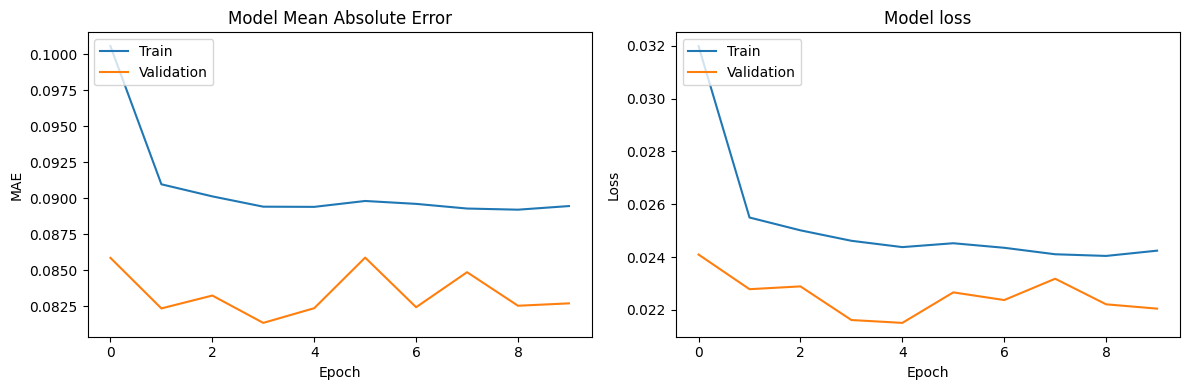

In [57]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])  
plt.plot(history.history['val_mae']) 
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [58]:
model.save('TrainedModel.h5')

c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


808/808 [==============================] - 4s 4ms/step


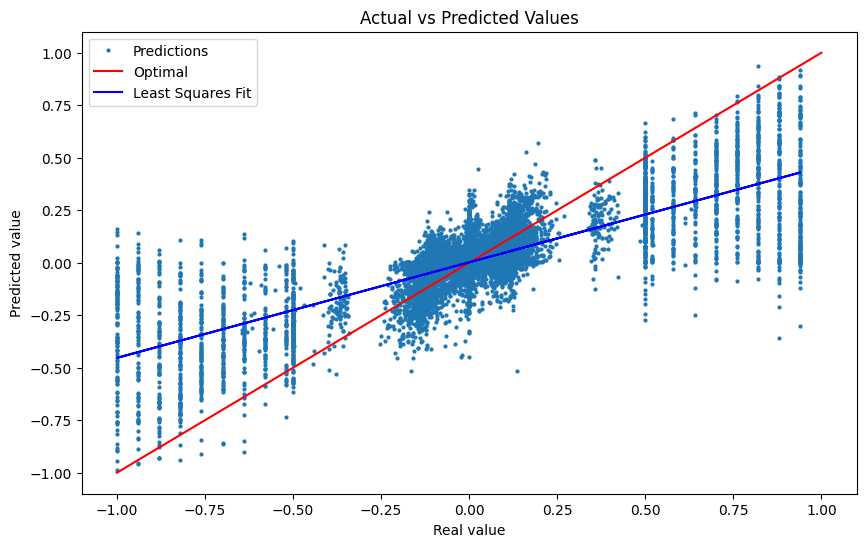

Predicted rating: [0.0476668], True rating: 0.3546003231942781
Predicted rating: [-0.1591824], True rating: -0.11765518506445785
Predicted rating: [0.18271436], True rating: 0.12282738823760918
Predicted rating: [-0.21050894], True rating: -0.11335448685042539
Predicted rating: [0.13552277], True rating: 0.12221932964701374
Predicted rating: [-0.13189201], True rating: -0.12075168774271203
Predicted rating: [0.19449428], True rating: 0.1437567363245948
Predicted rating: [0.00308147], True rating: -0.14968816710071503
Predicted rating: [0.15934813], True rating: 0.14067366315186947
Predicted rating: [0.02221824], True rating: -0.35728822041956776
Predicted rating: [0.13615245], True rating: 0.34972753956042857
Predicted rating: [-0.14019293], True rating: -0.3690169889883561
Predicted rating: [0.15157625], True rating: 0.5
Predicted rating: [-0.07633891], True rating: -0.5
Predicted rating: [0.08261201], True rating: 0.52
Predicted rating: [-0.2871144], True rating: -0.5
Predicted ratin

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Predict the ratings for the test data
y_pred = model.predict(x_test[:30000])

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.plot(y_test[:30000], y_pred, marker='o', linestyle='None', markersize=2.0, label='Predictions')

# Line x=y for perfect predictions
plt.plot([-1, 1], [-1, 1], color='red', label='Optimal')

# Least squares fit line
coeff = np.polyfit(y_test[:30000].flatten(), y_pred.flatten(), 1)
fit_line = np.polyval(coeff, y_test[:30000].flatten())
plt.plot(y_test[:30000], fit_line, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()

# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")


In [60]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
